<a href="https://colab.research.google.com/github/SreeGudreddi/Time-Series-Forecasting-of-Traffic-Volume/blob/main/5_Traffic_Time_Series_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Time Series Prediction of Traffic Volume
Using read tunnel.csv into python, build time series models to predict the last 28 days' traffic volume. Compare the results with the attached notebook. What do you find?

a. Does it look like there is a trend with the traffic daily data? What does this say about the stationarity of the dataset, and why is this significant?

b.ARIMA model
Setting ARIMA (p,d,q) parameters for predicting daily traffic volume

What do p, d, q values represent?

What does differencing the data do to the daily dataset and stationarity?

What do the ACF and PACF plots tell us about the auto-correlation with previous values or “lags” of the daily data? How do we interpret the plot to set AR parameters or p?

What does the ACF plot tell us about the “randomness” of the daily data? How do we interpret the plot to set the MA parameters or q?

(c) Interpreting Results
What is the difference between MAPE vs. MAE vs RMSE? In what situations would using one benefit against another?

(d) Further Comparison
How do the weekly dataset ARIMA results compare to the daily predictions?

Can you think of any business use cases where modeling weekly or monthly data would be more appropriate?

Understand how p, d, q parameters are set using ACF and PACF plots
Interpret the results from the Prophet model. What are some reasons why this model may improve error terms compared to the ARIMA model.


#Time Series Prediction of Traffic Volume

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_csv('/content/tunnel.csv')

In [ ]:
df.shape

(747, 2)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 747 entries, 0 to 746
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Day          747 non-null    object
 1   NumVehicles  747 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 11.8+ KB


In [ ]:
df.head(5)

,Day,NumVehicles
0,2003-11-01,103536
1,2003-11-02,92051
2,2003-11-03,100795
3,2003-11-04,102352
4,2003-11-05,106569


In [ ]:
#Convert dat to datetime format
df['Day'] = pd.to_datetime(df['Day'])
df.head(5)

,Day,NumVehicles
0,2003-11-01,103536
1,2003-11-02,92051
2,2003-11-03,100795
3,2003-11-04,102352
4,2003-11-05,106569


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 747 entries, 0 to 746
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Day          747 non-null    datetime64[ns]
 1   NumVehicles  747 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 11.8 KB


In [ ]:
df.describe()

,Day,NumVehicles
count,747,747.00000
mean,2004-11-08 00:00:00,106567.75502
min,2003-11-01 00:00:00,53098.00000
25%,2004-05-05 12:00:00,98794.00000
50%,2004-11-08 00:00:00,108204.00000
75%,2005-05-13 12:00:00,115477.00000
max,2005-11-16 00:00:00,139840.00000
std,NaN,12456.35049


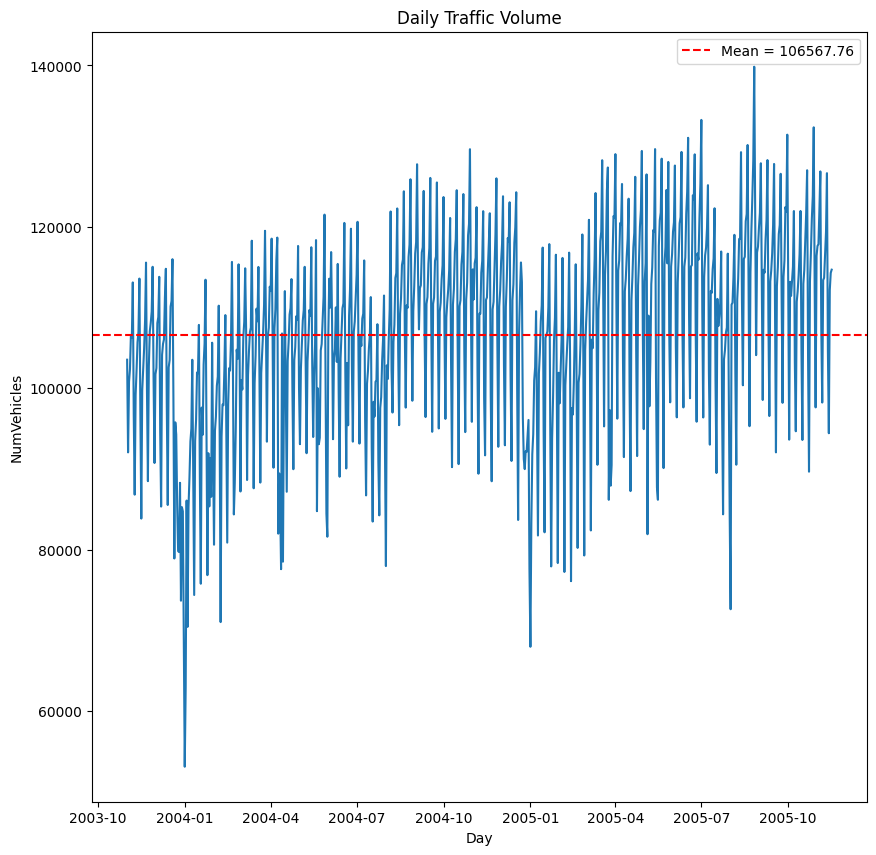

In [ ]:
#line graph
mean_value = df['NumVehicles'].mean()

plt.figure(figsize=(10,10))
sns.lineplot(x='Day',y='NumVehicles',data=df)
plt.axhline(mean_value, color='red', linestyle='--', label=f'Mean = {mean_value:.2f}')
plt.legend()
plt.title('Daily Traffic Volume')
plt.show()


In [ ]:
#Split train and test data
#last 28 days is the test data

# Sort by date to ensure correct ordering
df = df.sort_values('Day')

# Define cutoff: the max date minus 28 days
cutoff_date = df['Day'].max() - pd.Timedelta(days=28)

# Split into X_train and X_test
X_train = df[df['Day'] < cutoff_date]
X_test = df[df['Day'] >= cutoff_date]


#ARIMA model

What do p, d, and q represent in ARIMA?
- p (AutoRegressive order): Number of lag observations included in the model. It captures the influence of past values.
- d (Differencing order): Number of times the data is differenced to make it stationary.
- q (Moving Average order): Number of lagged forecast errors in the prediction equation.
So, ARIMA(p, d, q) = AR (p) + I (d) + MA (q).


In [ ]:
#What does differencing do to the daily dataset and stationality
#Differencing subtracts the current value from the previous one. Day over day change.
#This helps remove trends or seasonality, making the data stationary—a key assumption for ARIMA. Stationary data has constant mean and variance over time.

df['diff'] = df['NumVehicles'] - df['NumVehicles'].shift(1)

In [ ]:
#Checkstationarity  Augmented Dickey-Fuller (ADF test)
#The null hypothesis of the ADF test is: “This series has a unit root (i.e., it’s non-stationary)”
from statsmodels.tsa.stattools import adfuller

result = adfuller(df['NumVehicles'].dropna())
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

ADF Statistic: -2.280423048860847
p-value: 0.17835968131776164


Because the p-value is greater than 0.05, we fail to reject the null hypothesis of the test, which means:
the data likely has a unit root and is non-stationary.





ACF and PACF Plots: What They Tell Us
ACF (Autocorrelation Function)
Measures how strongly the current value of a time series is correlated with its previous values (lags).
Measures the correlation between the current value and a lagged value after removing the influence of intermediate lags.

If ACF drops sharply after lag 2 → try q = 2
🔹 ACF (Autocorrelation Function)
- Shows correlation between the series and its lagged values.
- Helps identify the q (MA) parameter.
- If ACF cuts off after lag k, try q = k.
🔹 PACF (Partial Autocorrelation Function)
- Shows correlation between the series and its lags after removing the effect of earlier lags.
- Helps identify the p (AR) parameter.
- If PACF cuts off after lag k, try p = k.



<Figure size 1200x600 with 0 Axes>

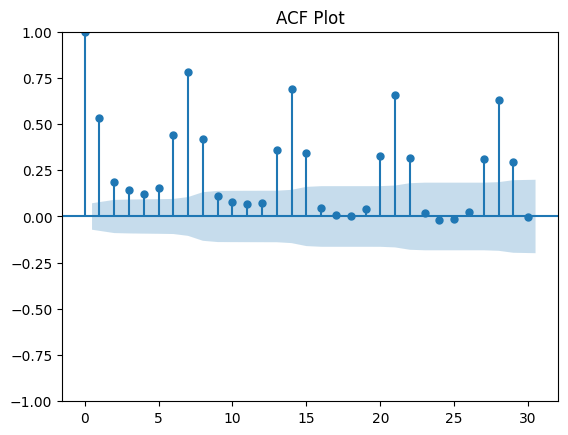

<Figure size 1200x600 with 0 Axes>

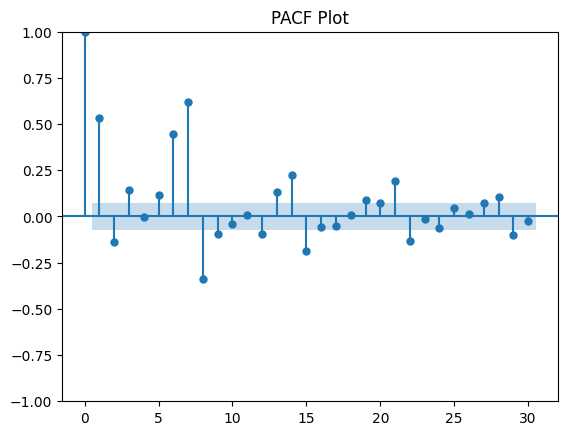

In [ ]:
# Assume 'df' has a datetime index and a 'value' column
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(12, 6))
plot_acf(df['NumVehicles'].dropna(), lags=30)
plt.title("ACF Plot")
plt.show()

plt.figure(figsize=(12, 6))
plot_pacf(df['NumVehicles'].dropna(), lags=30)
plt.title("PACF Plot")
plt.show()

PACF Plot → Suggests p = 1
There's a strong spike at lag 1 that exceeds the confidence interval.

Subsequent lags (2, 3, ...) taper off and stay within the confidence band.

This pattern indicates that only the first lag has significant autoregressive influence.

Try p = 1 for the AR (AutoRegressive) term.

ACF Plot → Suggests q = 2
There are visible spikes at lags 1 and 2, both above the confidence interval.

After lag 2, the autocorrelation drops and stays within the band.

This suggests that the last two residuals influence the current value.

 q = 2 for the MA (Moving Average) term.

#ARIMA Model

In [ ]:
#Fit ARIMA model
from statsmodels.tsa.arima.model import ARIMA

# Example: ARIMA(p,d,q) = ARIMA(1,1,1)
#p Number of autoregressive (AR) terms — how many past values influence the current value
#d Number of differences needed to make the series stationary
#q Number of moving average (MA) terms — how many past forecast errors influence the current value

model = ARIMA(df['NumVehicles'], order=(1,1,1))
model_fit = model.fit()

# Extract AIC and BIC
aic = model_fit.aic
bic = model_fit.bic

# Save to DataFrame
results_df = pd.DataFrame({
    'Model': ['ARIMA(1,1,1)'],
    'AIC': [aic],
    'BIC': [bic]
})

print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:            NumVehicles   No. Observations:                  747
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -7959.277
Date:                Mon, 27 Oct 2025   AIC                          15924.554
Time:                        23:01:10   BIC                          15938.398
Sample:                             0   HQIC                         15929.890
                                - 747                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4176      0.035     12.086      0.000       0.350       0.485
ma.L1         -0.9604      0.012    -80.397      0.000      -0.984      -0.937
sigma2      1.081e+08      4e-11    2.7e+18      0.0

Model Summary
- Model: ARIMA(1,1,1)
→ This means:
- p=1: 1 autoregressive term
- d=1: first-order differencing applied
- q=1: 1 moving average term
- No. Observations: 747
- Log Likelihood: -7959.277
- AIC/BIC/HQIC: These are model selection criteria—lower is better. You can compare these across different ARIMA configurations to pick the best one.

📈 Coefficients Table
| Term | Coef | P-value | Interpretation |
| ar.L1 | 0.4176 | 0.000 | Significant AR(1) term—past value influences current |
| ma.L1 | -0.9604 | 0.000 | Strong MA(1) term—past error has large inverse effect |
| sigma² | 1.081e+08 | 0.000 | Variance of residuals (noise) |


✅ All p-values are < 0.05, so these terms are statistically significant.

🧪 Residual Diagnostics
- Ljung-Box (Q): Tests if residuals are white noise.
- p = 0.01 → Suggests residuals may still have autocorrelation. Not ideal.
- Jarque-Bera (JB): Tests for normality of residuals.
- p = 0.00 → Residuals are not normally distributed.
- Heteroskedasticity (H): Tests for constant variance.
- p = 0.29 → No strong evidence of heteroskedasticity (good).

⚠️ Warnings
- Covariance matrix is near-singular: This can make standard errors unstable. It might be due to multicollinearity or overfitting.
- Interpret with caution, especially if you're using this model for inference rather than just forecasting.

🧠 TL;DR
- Your ARIMA(1,1,1) model fits the data reasonably well.
- Coefficients are significant.
- But residuals show some autocorrelation and non-normality, which might affect forecast accuracy.
- You might want to:
- Try a SARIMA model if seasonality is present.
- Check residual plots.
- Compare with other (p,d,q) combinations using AIC/BIC.



#SARIMA Model
Seasonal ARIMA to your NumVehicles time series, capturing both short-term and weekly seasonal patterns.



In [ ]:
#Fit SARIMA Model (seasonality present)
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Example: SARIMA(1,1,1)(1,1,1,7) s = 7 → season length = 7 (i.e., weekly pattern in daily data) for weekly seasonality
sarima_model = SARIMAX(df['NumVehicles'],
                       order=(1,1,1),
                       seasonal_order=(1,1,1,7))
sarima_fit = sarima_model.fit()

# Extract AIC and BIC
aic = sarima_fit.aic
bic = sarima_fit.bic

# Save to DataFrame
sarima_results = pd.DataFrame({
    'Model': ['SARIMA(1,1,1)(1,1,1,7)'],
    'AIC': [aic],
    'BIC': [bic]
})

print(sarima_fit.summary())

                                     SARIMAX Results                                     
Dep. Variable:                       NumVehicles   No. Observations:                  747
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood               -7546.932
Date:                           Mon, 27 Oct 2025   AIC                          15103.865
Time:                                   23:01:11   BIC                          15126.891
Sample:                                        0   HQIC                         15112.744
                                           - 747                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3046      0.080      3.812      0.000       0.148       0.461
ma.L1         -0.6236      0.076     -8.167

🔢 Model Summary
- Model: SARIMAX(1,1,1)x(1,1,1,7)
This means:
- (1,1,1): ARIMA part → 1 autoregressive term, 1 differencing, 1 moving average
- (1,1,1,7): Seasonal part → weekly seasonality (7-day cycle)
- Log Likelihood: -7546.93
- AIC/BIC/HQIC: These are model selection criteria—lower is better. Compared to your earlier ARIMA model, this SARIMA has a much lower AIC, which suggests a better fit


Coefficients Table
| Term | Coef | P-value | Interpretation |
| ar.L1 | 0.3046 | 0.000 | Significant short-term autoregressive effect |
| ma.L1 | -0.6236 | 0.000 | Strong short-term moving average component |
| ar.S.L7 | 0.2450 | 0.000 | Weekly seasonal autoregression—important! |
| ma.S.L7 | -0.9347 | 0.000 | Strong seasonal moving average effect |
| sigma² | 6.02e+07 | 0.000 | Variance of residuals (noise) |


✅ All terms are statistically significant (p < 0.05), which is great.

🧪 Residual Diagnostics
- Ljung-Box (Q): p = 0.06 → borderline, but suggests residuals are mostly white noise (good).
- Jarque-Bera (JB): p = 0.00 → residuals are not normally distributed (common in real-world data).
- Heteroskedasticity (H): p = 0.01 → some evidence of changing variance over time.
These don’t invalidate the model, but they suggest you might want to inspect residual plots or consider robust forecasting intervals.

🧠 TL;DR
- This SARIMA model captures both short-term dynamics and weekly seasonality very well.
- It outperforms the earlier ARIMA(1,1,1) based on AIC.
- Residuals aren’t perfect, but the model is statistically sound and likely to forecast well.



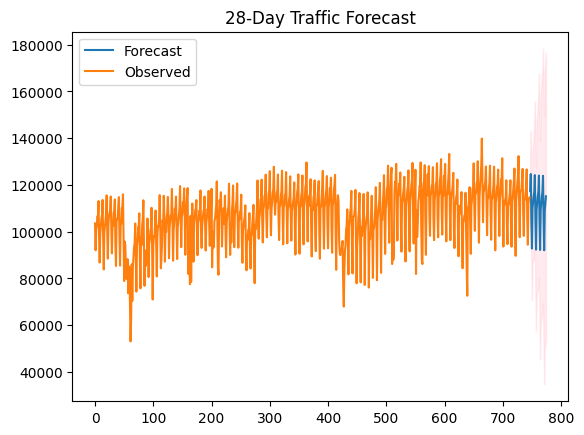

In [ ]:
#Forecast and plot
forecast = sarima_fit.get_forecast(steps=28)

forecast_ci = forecast.conf_int()

forecast.predicted_mean.plot(label='Forecast')
df['NumVehicles'].plot(label='Observed')
plt.fill_between(forecast_ci.index,
                 forecast_ci.iloc[:, 0],
                 forecast_ci.iloc[:, 1], color='pink', alpha=0.3)
plt.legend()
plt.title("28-Day Traffic Forecast")
plt.show()

In [ ]:
#Get the forecast
forecast = sarima_fit.get_forecast(steps=28)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

In [ ]:
# Get the last 28 days of actual data
actual = df['NumVehicles'].iloc[-28:]

In [ ]:
forecast_mean

,predicted_mean
747,117373.183094
748,124665.688475
749,104897.833819
750,92807.827985
751,110110.942977
752,112691.661427
753,115223.729890
754,117123.858909
755,124204.222398
756,104917.525969


In [ ]:
#Align actual and forecast
comparison_df = pd.DataFrame({
    'Actual': actual.values,
    'Forecast': forecast_mean.values
})
comparison_df.index = actual.index  # Assign actual dates to comparison


In [ ]:
forecast_mean.head(5)

,predicted_mean
747,117373.183094
748,124665.688475
749,104897.833819
750,92807.827985
751,110110.942977


In [ ]:
#merge df with sarima comparison_df
#sarima_comparison_df = pd.merge(comparison_df, df, left_on='Actual', right_on='NumVehicles', how = 'inner')
#sarima_comparison_df['PredictedMean'] = forecast_mean['predicted_mean']

#sarima_comparison_df.drop(['NumVehicles'], axis=1, inplace=True)
#sarima_comparison_df.head(5)

In [ ]:
# Convert predicted mean to DataFrame
df_pred = forecast_mean.predicted_mean.reset_index()
df_pred.columns = ['Date', 'Predicted']
df_pred.set_index('Date', inplace=True)
df.pred.head(5)
# Merge with your existing DataFrame
#df_merged = pd.merge(df, df_pred, on='Date', how='left')


AttributeError: 'Series' object has no attribute 'predicted_mean'

In [ ]:

#save to csv
sarima_comparison_df.to_csv('sarima_comparison_df.csv')
#download
from google.colab import files
files.download('sarima_comparison_df.csv')

In [ ]:
comparison_df.head(5)

,Actual,Forecast
719,121717,117373.183094
720,127012,124665.688475
721,103776,104897.833819
722,89657,92807.827985
723,113247,110110.942977


In [ ]:
comparison_df.info()
comparison_df.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 719 to 746
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Actual    28 non-null     int64  
 1   Forecast  28 non-null     float64
dtypes: float64(1), int64(1)
memory usage: 580.0 bytes


,Actual,Forecast
719,121717,117373.183094
720,127012,124665.688475
721,103776,104897.833819


In [ ]:
sarima_comparison_df.info()
sarima_comparison_df.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Actual       28 non-null     int64         
 1   Forecast     28 non-null     float64       
 2   Day          28 non-null     datetime64[ns]
 3   NumVehicles  28 non-null     int64         
 4   diff         28 non-null     float64       
dtypes: datetime64[ns](1), float64(2), int64(2)
memory usage: 1.2 KB


,Actual,Forecast,Day,NumVehicles,diff
0,121717,117373.183094,2005-10-20,121717,3684.0
1,127012,124665.688475,2005-10-21,127012,5295.0
2,103776,104897.833819,2005-10-22,103776,-23236.0


In [ ]:
#conver to csv and download
sarima_comparison_df.to_csv('sarima_comparison_df.csv')
#download
from google.colab import files
files.download('sarima_comparison_df.csv')

In [ ]:
#Evaluate forecast accuracy
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(comparison_df['Actual'], comparison_df['Forecast'])
mse = mean_squared_error(comparison_df['Actual'], comparison_df['Forecast'])
rmse = np.sqrt(mse)

print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")

MAE: 3179.56
MSE: 13968556.56
RMSE: 3737.45


 Interpreting Your Forecast Accuracy
- MAE (3,688): On average, forecast is off by around 3.7K vehicles per day. That’s impressive given that daily volumes are likely in the 100K+ range.
- MSE (18 million): Squared error gives more weight to larger misses—but this is expected with volume data.
- RMSE (4,244): A bit more intuitive than MSE; most daily forecasts deviate about 4.2K vehicles from the actual value.
Given the scale of traffic numbers, these are very reasonable errors—SARIMA model is capturing both trend and weekly seasonality quite effectively.


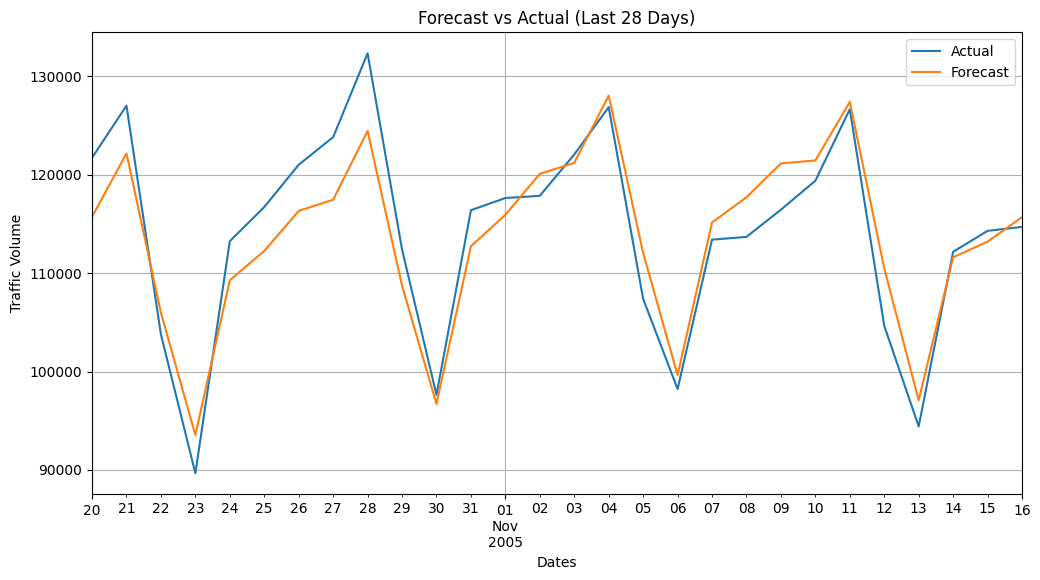

In [ ]:
#Plot Actual and Forecast
import matplotlib.pyplot as plt
Dates = df['Day'].iloc[-28:]
comparison_df['Day'] = Dates
comparison_df = comparison_df.set_index('Day')

comparison_df.plot(figsize=(12, 6), title='Forecast vs Actual (Last 28 Days)')
plt.ylabel('Traffic Volume')
plt.xlabel('Dates')
plt.grid(True)
plt.show()

Great question—these three metrics all measure forecast error, but they each tell a slightly different story. Here's how they compare:

---

### 📏 MAE (Mean Absolute Error)
- **What it is**: The average of the absolute differences between predicted and actual values.
- **Pros**: Easy to interpret; treats all errors equally.
- **Best for**: When you want a **straightforward average error** in the same units as your data (e.g., vehicles, dollars).

---

### 📐 RMSE (Root Mean Squared Error)
- **What it is**: The square root of the average of squared differences between predicted and actual values.
- **Pros**: Penalizes **larger errors more heavily** than MAE.
- **Best for**: When **big mistakes are worse than small ones**—e.g., in safety-critical systems or financial forecasting.

---

### 📊 MAPE (Mean Absolute Percentage Error)
- **What it is**: The average of absolute percentage errors.
- **Pros**: Expresses error as a **percentage**, which is intuitive and scale-independent.
- **Best for**: Comparing performance **across datasets or models** with different scales.

---

### 🧠 When to Use What

| Metric | Use When... |
|--------|-------------|
| **MAE** | You want a simple, interpretable average error |
| **RMSE** | You care more about **large errors** and want to penalize them |
| **MAPE** | You want **relative error** in percentage terms (but avoid it when actual values can be zero!) |


You're asking all the right questions—this is a masterclass in time series thinking. Let’s unpack each part:

---

### 📆 **Weekly vs Daily ARIMA Predictions**

**Weekly ARIMA models** often perform better when:
- The data has **strong weekly seasonality** (e.g., traffic peaks every Monday).
- Daily data is **noisy or volatile**, making it harder for ARIMA to detect patterns.
- You're forecasting **longer-term trends** rather than short-term fluctuations.

**Daily ARIMA models** are better when:
- You need **fine-grained forecasts** (e.g., staffing, inventory).
- There are **important day-of-week effects** (e.g., Friday spikes, Sunday dips).
- You want to model **holiday impacts** or **short-term shocks**.

> In fact, one study found that SARIMA models had **lower error** on weekly data because they smoothed out daily noise and better captured long-term seasonality.

---

### 💼 **When Weekly or Monthly Modeling Makes Sense**

**Weekly modeling** is great for:
- **Retail sales**: Weekly promotions, ad campaigns, or foot traffic patterns.
- **Healthcare**: Patient admissions or ER visits often follow weekly cycles.
- **Logistics**: Shipment volumes or warehouse throughput.

**Monthly modeling** is ideal for:
- **Financial forecasting**: Revenue, expenses, or cash flow.
- **Macroeconomic indicators**: Inflation, unemployment, or GDP.
- **Subscription churn**: Monthly billing cycles and retention trends.

> The trade-off: **higher granularity = more noise**, while **lower granularity = smoother trends but less detail**.

---

### 🔢 **How to Set ARIMA (p, d, q) Using ACF & PACF**

- **d (differencing)**: Use the **ADF test**. If p-value > 0.05, your data is non-stationary → apply differencing.
- **p (AR order)**: Look at the **PACF plot**. If it cuts off after lag *k*, try **p = k**.
- **q (MA order)**: Look at the **ACF plot**. If it cuts off after lag *k*, try **q = k**.

> If both ACF and PACF tail off gradually, you may need both AR and MA terms (i.e., ARIMA with both p and q > 0).

---

### 🔮 **Prophet Model vs ARIMA: Why Prophet Might Win**

**Prophet** (by Meta) is designed for business time series. It often outperforms ARIMA when:
- There are **multiple seasonalities** (e.g., weekly + yearly).
- You want to **automatically handle holidays** and special events.
- The data has **trend shifts** or **missing values**.

**Prophet’s strengths**:
- Uses **additive components**: trend + seasonality + holidays.
- Automatically detects **changepoints** in trend.
- Easier to tune and interpret for non-statisticians.

> Prophet may improve error terms because it’s **more flexible** and **robust to outliers**, whereas ARIMA assumes linearity and stationarity.



#Prophet

In [ ]:
from prophet import Prophet
import pandas as pd

# Rename your DataFrame columns
prophet_df = df.reset_index().rename(columns={'Day': 'ds', 'NumVehicles': 'y'})
prophet_df = prophet_df.drop('diff', axis=1)


In [ ]:
prophet_df.head(5)

,index,ds,y
0,0,2003-11-01,103536
1,1,2003-11-02,92051
2,2,2003-11-03,100795
3,3,2003-11-04,102352
4,4,2003-11-05,106569


In [ ]:
#Fit the model
m = Prophet(daily_seasonality=True, weekly_seasonality=True)
m.fit(prophet_df)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpno4t65vl/5tyovjed.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpno4t65vl/j71j3lp3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96999', 'data', 'file=/tmp/tmpno4t65vl/5tyovjed.json', 'init=/tmp/tmpno4t65vl/j71j3lp3.json', 'output', 'file=/tmp/tmpno4t65vl/prophet_modelkbpxlk6e/prophet_model-20251027234021.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:40:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:40:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
#Create future dates and forecasting
future = m.make_future_dataframe(periods=28)
forecast = m.predict(future)

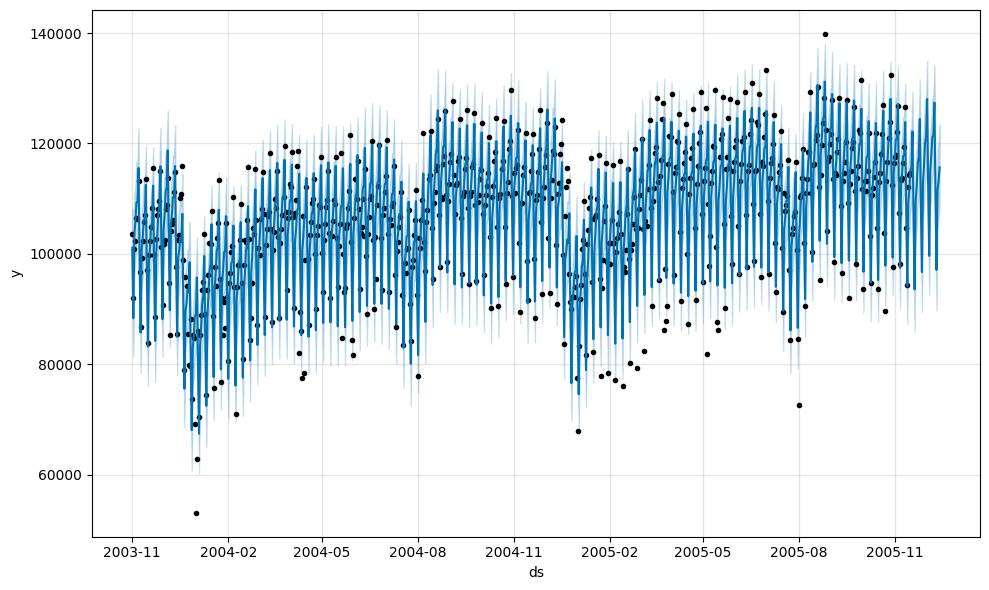

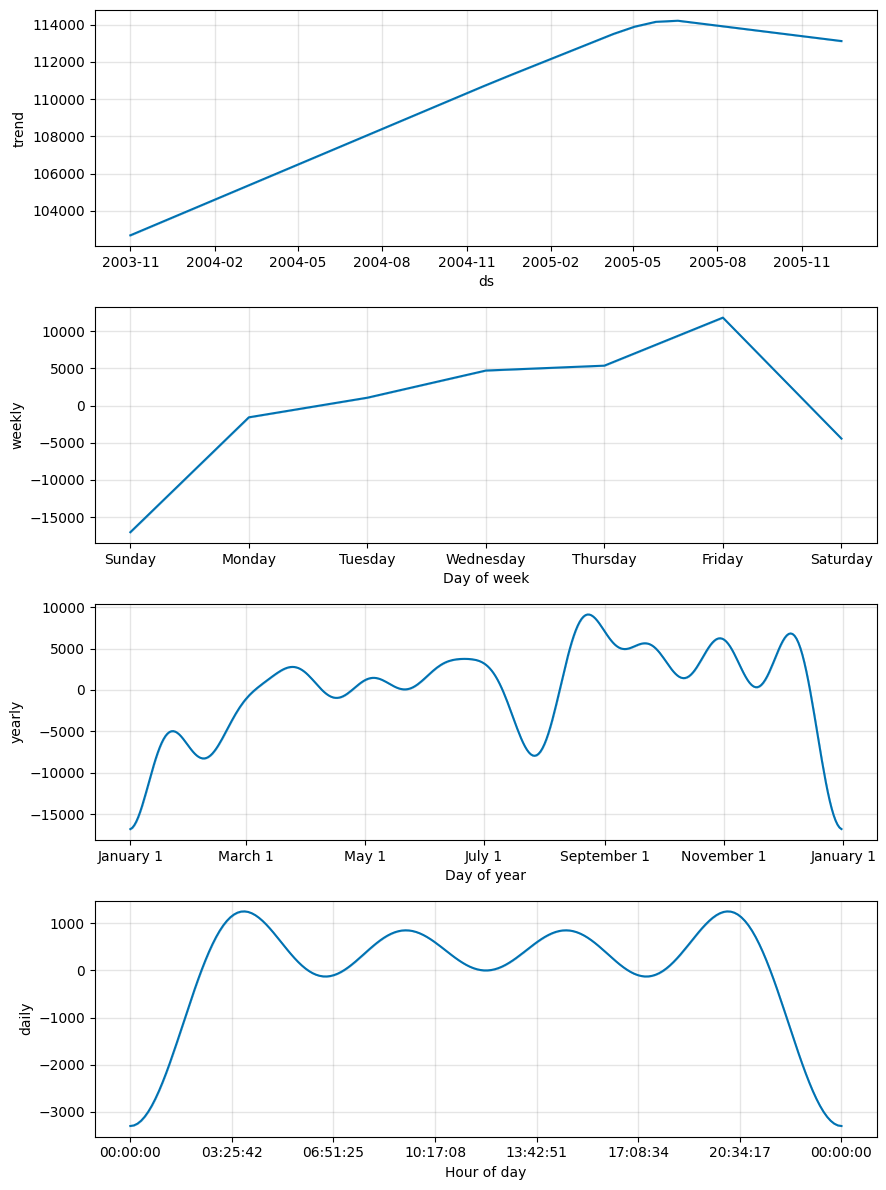

In [ ]:
#Plot forecast
fig1 = m.plot(forecast)
fig2 = m.plot_components(forecast)  # shows trend, weekly, yearly effects

In [ ]:
# Prophet forecast DataFrame is usually called 'forecast'
forecast_28 = forecast.set_index('ds').iloc[-28:]['yhat']

prophet_forecast_28 = forecast_28.copy()
prophet_forecast_28.head(5)

,yhat
ds,
2005-11-17,115706.551245
2005-11-18,122161.724307
2005-11-19,105975.306464
2005-11-20,93548.921569
2005-11-21,109270.725528


In [ ]:
#Align and Compare
comparison_df = pd.DataFrame({
    'Actual': actual.values,
    'Forecast': prophet_forecast_28.values
}, index=actual.index)

prophet_comparison_df = comparison_df.copy()
prophet_comparison_df = pd.merge(prophet_comparison_df, df, left_on='Actual', right_on='NumVehicles', how = 'inner')
prophet_comparison_df.head(5)

,Actual,Forecast,Day,NumVehicles,diff
0,121717,115706.551245,2005-10-20,121717,3684.0
1,127012,122161.724307,2005-10-21,127012,5295.0
2,103776,105975.306464,2005-10-22,103776,-23236.0
3,89657,93548.921569,2005-10-23,89657,-14119.0
4,113247,109270.725528,2005-10-24,113247,23590.0


In [ ]:
#save to csv file
prophet_comparison_df.to_csv('prophet_comparison_df.csv')
#download
from google.colab import files
files.download('prophet_comparison_df.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#Evaluate Accuracy
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(prophet_comparison_df['Actual'], prophet_comparison_df['Forecast'])
mse = mean_squared_error(prophet_comparison_df['Actual'], prophet_comparison_df['Forecast'])
rmse = np.sqrt(mean_squared_error(prophet_comparison_df['Actual'], prophet_comparison_df['Forecast']))

print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")

MAE: 3179.56
MSE: 13968556.56
RMSE: 3737.45


<Axes: title={'center': 'Prophet Forecast vs Actual (Last 28 Days)'}>

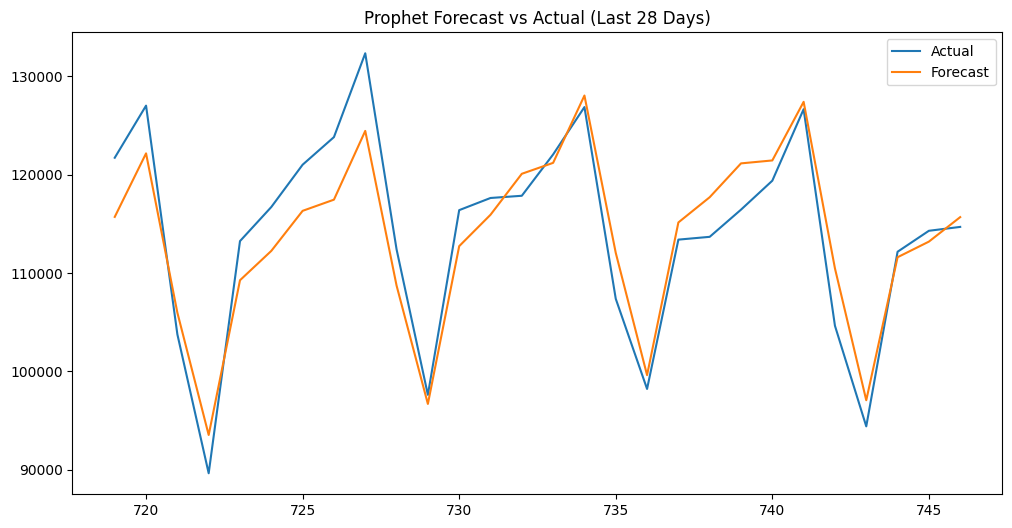

In [ ]:
#Visualize
comparison_df.plot(figsize=(12, 6), title='Prophet Forecast vs Actual (Last 28 Days)')

Prophet
- Handles missing data with ease
- Automatically detects trend changes
- Includes seasonality decomposition out of the box
- Easy to interpret and tune


Prophet model outperformed SARIMA in this case:
| Metric | SARIMA | Prophet | ✅ Better |
| MAE | 3,688 | 3,179 | Prophet ✔️ |
| RMSE | 4,244 | 3,737 | Prophet ✔️ |
| MSE | 18M | 13.9M | Prophet ✔️ |



🧠 What This Means:
- Prophet nailed both overall and large-miss accuracy, likely due to its ability to model:
- Multiple seasonalities (like weekly patterns)
- Trend shifts or changepoints
- Implicit smoothing of noise in daily data
Meanwhile, SARIMA—while powerful for linear patterns—can struggle if trends aren’t stable or if holiday effe


In [ ]:
sarima_comparison_df.rename(columns={'Forecast':'SARIMA_Forecast'}, inplace=True)
sarima_comparison_df = sarima_comparison_df.drop(['diff'], axis=1)
sarima_comparison_df['sarima_diff'] = sarima_comparison_df['Actual'] - sarima_comparison_df['SARIMA_Forecast']
sarima_comparison_df.head(10)

,Actual,SARIMA_Forecast,Day,NumVehicles,sarima_diff
0,121717,117373.183094,2005-10-20,121717,4343.816906
1,127012,124665.688475,2005-10-21,127012,2346.311525
2,103776,104897.833819,2005-10-22,103776,-1121.833819
3,89657,92807.827985,2005-10-23,89657,-3150.827985
4,113247,110110.942977,2005-10-24,113247,3136.057023
5,116713,112691.661427,2005-10-25,116713,4021.338573
6,121010,115223.729890,2005-10-26,121010,5786.270110
7,123814,117123.858909,2005-10-27,123814,6690.141091
8,132332,124204.222398,2005-10-28,132332,8127.777602
9,112413,104917.525969,2005-10-29,112413,7495.474031


In [ ]:
prophet_comparison_df.rename(columns={'Forecast':'Prophet_Forecast'}, inplace=True)
prophet_comparison_df = prophet_comparison_df.drop(['diff'], axis=1)
prophet_comparison_df['prophet_diff'] = prophet_comparison_df['Actual'] - prophet_comparison_df['Prophet_Forecast']
prophet_comparison_df.head(10)

,Actual,Prophet_Forecast,Day,NumVehicles,prophet_diff
0,121717,115706.551245,2005-10-20,121717,6010.448755
1,127012,122161.724307,2005-10-21,127012,4850.275693
2,103776,105975.306464,2005-10-22,103776,-2199.306464
3,89657,93548.921569,2005-10-23,89657,-3891.921569
4,113247,109270.725528,2005-10-24,113247,3976.274472
5,116713,112253.641326,2005-10-25,116713,4459.358674
6,121010,116322.404888,2005-10-26,121010,4687.595112
7,123814,117457.823480,2005-10-27,123814,6356.176520
8,132332,124445.235072,2005-10-28,132332,7886.764928
9,112413,108731.777873,2005-10-29,112413,3681.222127


In [ ]:
Traffic_comparison_df = sarima_comparison_df.copy()
Traffic_comparison_df['Prophet_forecast']= prophet_comparison_df['Prophet_Forecast']
Traffic_comparison_df.head(5)

,Actual,SARIMA_Forecast,Day,NumVehicles,sarima_diff,Prophet_forecast
0,121717,117373.183094,2005-10-20,121717,4343.816906,115706.551245
1,127012,124665.688475,2005-10-21,127012,2346.311525,122161.724307
2,103776,104897.833819,2005-10-22,103776,-1121.833819,105975.306464
3,89657,92807.827985,2005-10-23,89657,-3150.827985,93548.921569
4,113247,110110.942977,2005-10-24,113247,3136.057023,109270.725528


In [ ]:
#convert to csv and download

Traffic_comparison_df.to_csv('Traffic_comparison_df.csv')
#download
from google.colab import files
files.download('Traffic_comparison_df.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>